# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science



## Final Project -  Lending Club Investments <img style="float: right; padding-right: 10px; width: 150px" src="https://i.imgur.com/2ptDvXd.png">


**Harvard University**<br/>
**Fall 2018**<br/>

**Group #47 Team Members**:<br/> 
Danielle Crumley<br/>
Mohamed Elsalmi<br/>
Victor Chen<br/>
Hoon Kang<br/>


<hr style="height:1.5pt">

### <font color='maroon'>Data Collection</font>


In [92]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split


%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join

<b>Load and combine all Lending Club data in ./Lending Club Project/data/
<br> Current Data: <font color='green'>2012 to 2018Q3</font></b>

In [ ]:
'''
#Reads file names in the defined path
data_path = './data/'
files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

#Read CSV and concatenate files into loan_df
df_list = []
for each in files:
    print('Reading:', each)
    df_list.append(pd.read_csv(data_path + each, header=1, skipfooter=2, engine='python'))
    clear_output(wait=True)
    
loan_df = pd.concat(df_list)

#Remove any excess rows that do not fit ('id' should always be empty)
loan_df = loan_df[loan_df['id'].isnull()]

print('Total Number of Rows:', '{:,}'.format(loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(loan_df.shape[1]))
loan_df.head(5)
'''

<b>Optional: Add Data from <font color='green'>2007-2011</font></b>

In [ ]:
'''
#Load in LoanStats_2007_2011.csv
tmp_df = pd.read_csv('./data/old/LoanStats_2007_2011.csv', header=1, engine='python')

#Remove any loans that do not meet the credit policy
tmp_df.truncate(after=tmp_df.index[tmp_df['id'] == 'Loans that do not meet the credit policy'].values[0]-1)

#Concatenate with loan_df
loan_df = pd.concat([loan_df, tmp_df])

#Remove any excess rows that do not fit ('id' should always be empty)
loan_df = loan_df[loan_df['id'].isnull()]

print('Total Number of Rows:', '{:,}'.format(loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(loan_df.shape[1]))
loan_df.head(5)
'''

In [4]:
#Saved as Pickle for faster speed
#loan_df.to_pickle('./data/loan_df.pkl')
loan_df = pd.read_pickle('./data/loan_df.pkl')

print('Total Number of Rows:', '{:,}'.format(loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(loan_df.shape[1]))
loan_df.head(5)

Total Number of Rows: 2,132,256
Total Number of Columns: 145


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,10000.0,10000.0,10000.0,36 months,9.67%,321.13,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,12000.0,12000.0,12000.0,36 months,6.62%,368.45,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,20800.0,20800.0,20800.0,36 months,13.53%,706.16,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,27050.0,27050.0,27050.0,36 months,10.99%,885.46,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4800.0,4800.0,4800.0,36 months,10.99%,157.13,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


<hr style="height:1.5pt">
### <font color='maroon'>Generate Labels for the Response Variable</font>
<br>We'd like to use <b>loan_status</b> as the basis for our response variable.
<br>There is a very clear signal on the risk of a loan when a loan is fully paid vs. charged off. <br>We can only use loans that have been closed as any open loans may still go either way. 


In [5]:
loan_df.groupby('loan_status')['loan_status'].agg('count').sort_values(ascending=False)

loan_status
Current                                                922081
Fully Paid                                             920849
Charged Off                                            229523
Late (31-120 days)                                      22951
Issued                                                  13621
In Grace Period                                         12665
Late (16-30 days)                                        6776
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1041
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

We will generate a <b>Risk</b> label where:
<br><b>0</b> - Low Risk to Fund (Fully Paid)
<br><b>1</b> - High Risk to Fund (Charged Off)

In [6]:
# Low Risk
loan_df['Risk'] = np.where(loan_df['loan_status']=='Fully Paid',0,np.nan)

# High Risk
loan_df['Risk'] = np.where(loan_df['loan_status']=='Charged Off',1,loan_df['Risk'])

We see that we have very imbalanced data. When we try to improve on the baseline, we will try undersampling or oversampling to deal with it.

In [7]:
loan_df.groupby('Risk')['Risk'].agg('count').sort_values(ascending=False)

Risk
0.0    920849
1.0    229523
Name: Risk, dtype: int64

<hr style="height:1.5pt">
### <font color='maroon'>EDA</font>

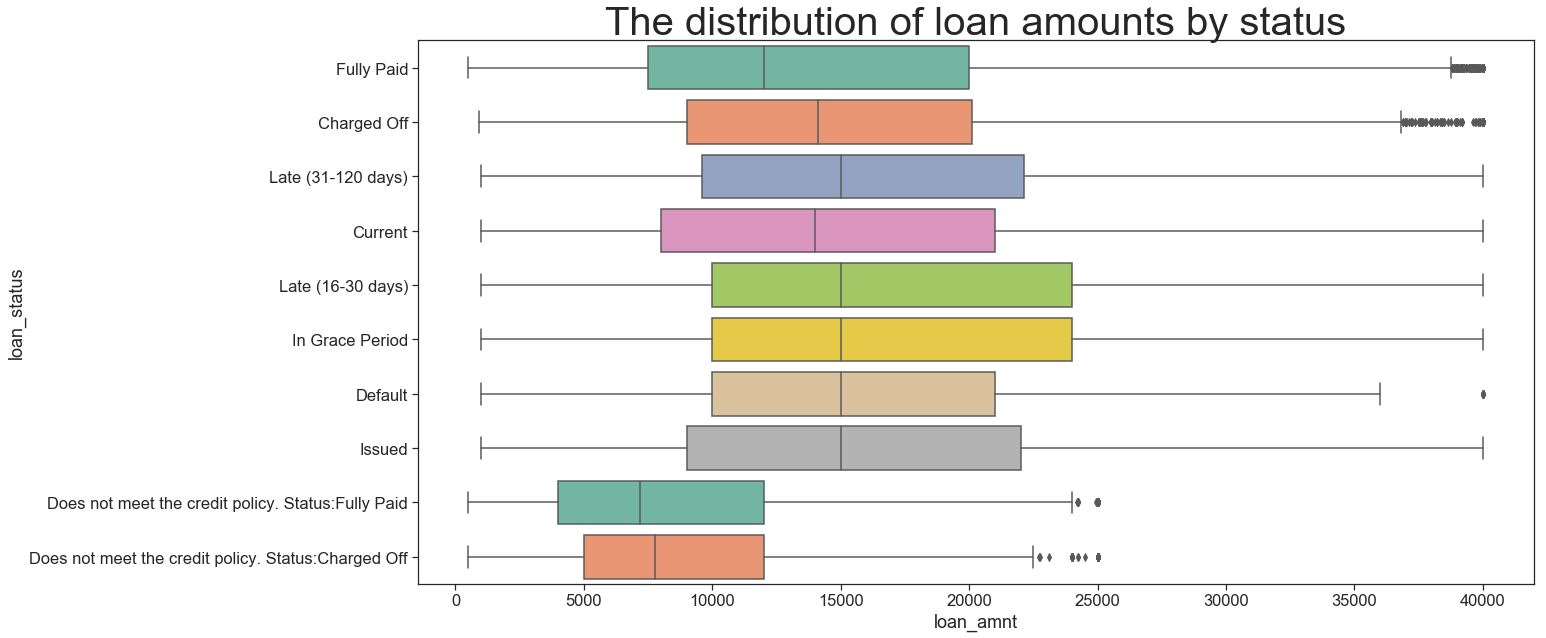

In [8]:
plt.subplots(figsize=(20,10))
plt.title("The distribution of loan amounts by status").set_size(40)
sns.boxplot(x="loan_amnt", y="loan_status", data=loan_df, palette='Set2');

**We can see a couple of things here: **

**1. Fully Paid loans tend to be smaller. This could be due to the age of the loans**

**2. Default has the highest count among other loan status.**

**3.In Grace Period and Late(16~30 days) have the highest loan amount and mean.**

**4. We should exclude "issued", and the loans that do not meet the credit policy**

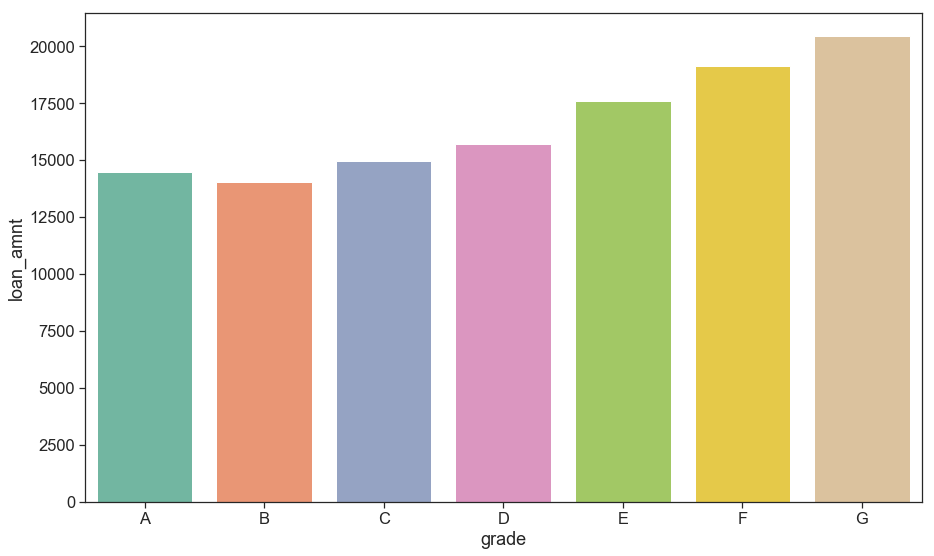

In [9]:
#Loan amount by grade
group = loan_df.groupby("grade").mean()
avg_loan = group['loan_amnt'].reset_index()
plt.subplots(figsize=(15,9))
sns.barplot(x='grade', y='loan_amnt', data=avg_loan, palette='Set2');

**We see here that the higher loan amount the lower the grade.**



**Doing the same for sub_grade.**

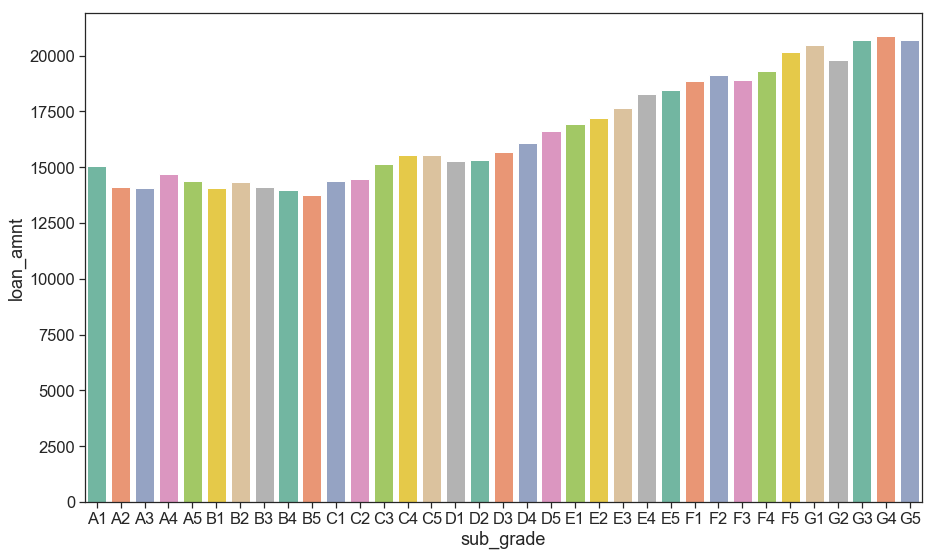

In [10]:
#Loan amount by sub_grade
group = loan_df.groupby("sub_grade").mean()
avg_loan = group['loan_amnt'].reset_index()
plt.subplots(figsize=(15,9))
sns.barplot(x='sub_grade', y='loan_amnt', data=avg_loan, palette='Set2');

**As expected, lower the subgrade the higher the loan amount.**


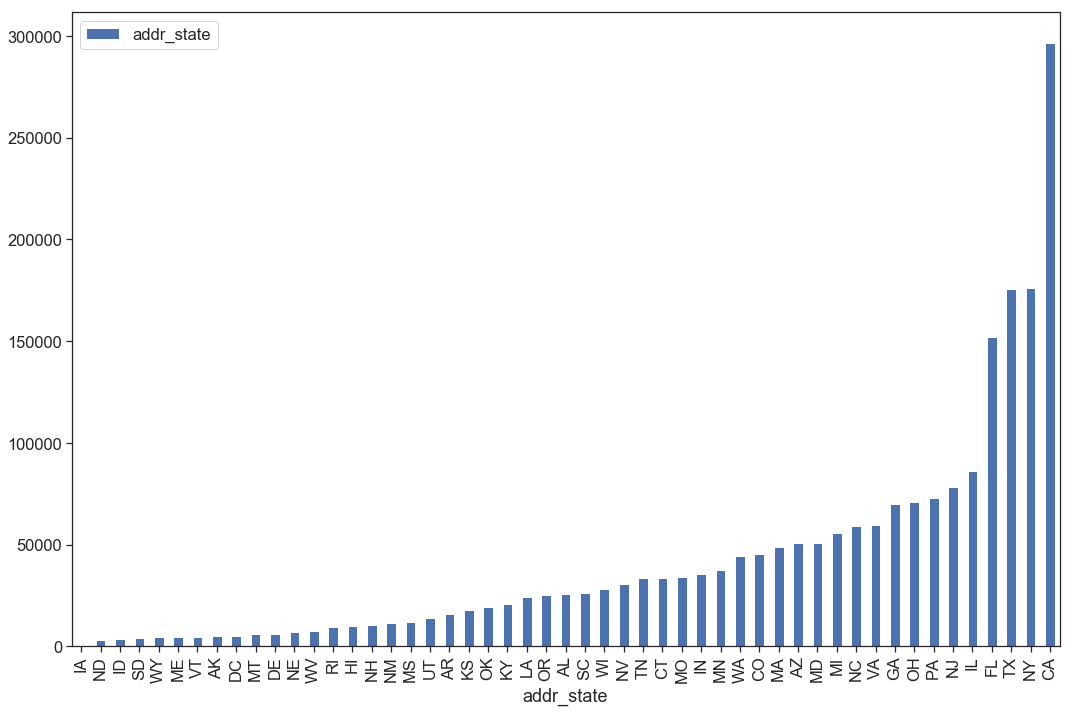

In [11]:
loan_origin=pd.DataFrame(loan_df.groupby('addr_state')['addr_state'].agg('count').sort_values(ascending=True))
loan_origin.plot(kind='bar', figsize=(15,10))
plt.tight_layout()

In [12]:
adress_loan = ['addr_state', 'loan_status']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(loan_df[adress_loan[0]], loan_df[adress_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Does not meet the credit policy. Status:Charged Off,Does not meet the credit policy. Status:Fully Paid,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
addr_state,,,,,,,,,,
AK,554,2104,4,1,4,2239,15,16,10,49
AL,3419,10864,18,8,24,10879,164,143,92,257
AR,2060,7036,7,6,9,6481,115,110,55,197
AZ,5483,21211,21,18,33,22563,255,344,141,559
CA,33274,118638,162,101,223,137011,1474,1863,837,3071
CO,3933,18585,22,13,52,21633,231,336,112,405
CT,2891,16087,19,12,50,13745,256,215,116,356
DC,394,1957,1,2,8,2624,30,22,10,34
DE,647,2673,6,4,18,2554,28,60,21,66


In [13]:
loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'])

dates = []

total_loans = []
fully_paid = []
charged_off = []

for year in range(2007,2019):
    for month in range(1,13):
        tmp = loan_df[loan_df['issue_d']==datetime(year,month,1)]
        dates.append(datetime(year,month,1))
        total_loans.append(tmp.shape[0])
        fully_paid.append(tmp[tmp['loan_status']=='Fully Paid'].shape[0])
        charged_off.append(tmp[tmp['loan_status']=='Charged Off'].shape[0])
     

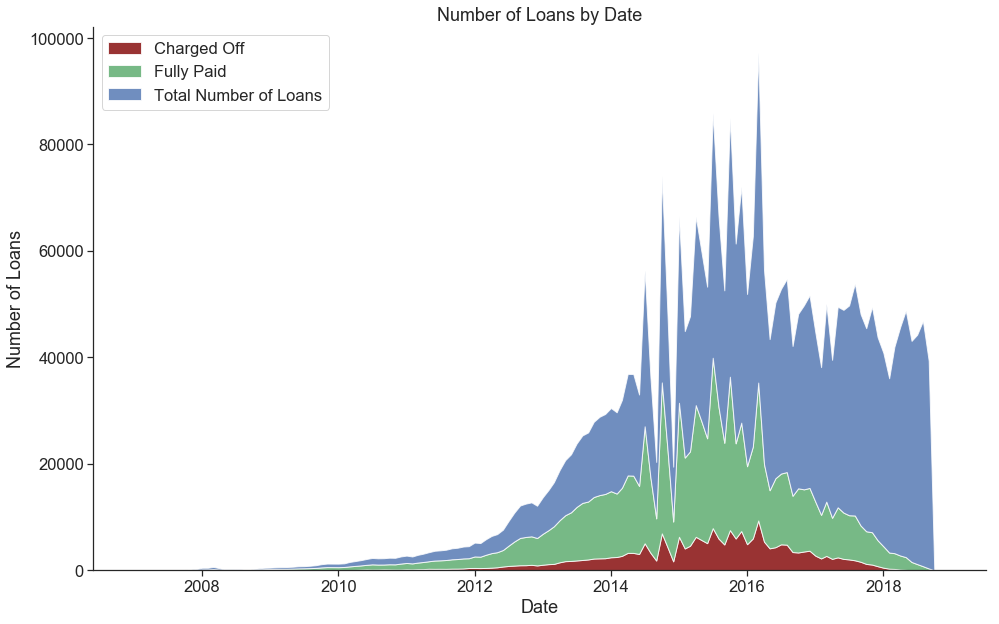

In [14]:
fig, ax = plt.subplots(figsize=(16,10))

plt.stackplot(dates,[charged_off,fully_paid,total_loans], 
              labels=['Charged Off','Fully Paid','Total Number of Loans'], 
              alpha=0.8,colors=['#800000', '#55a868', '#4c72b0'])


ax.set_title('Number of Loans by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Loans')
plt.legend(loc='upper left')

sns.despine();

In [15]:
#Total Loan Age = (Last Payment Date - Issue Date)/30 days 
loan_df['last_pymnt_d'] = pd.to_datetime(loan_df['last_pymnt_d'])
loan_df['Total_Loan_Age'] = loan_df['last_pymnt_d'] - loan_df['issue_d']
loan_df['Total_Loan_Age'] = loan_df['Total_Loan_Age'].apply(lambda x: x.days/30)


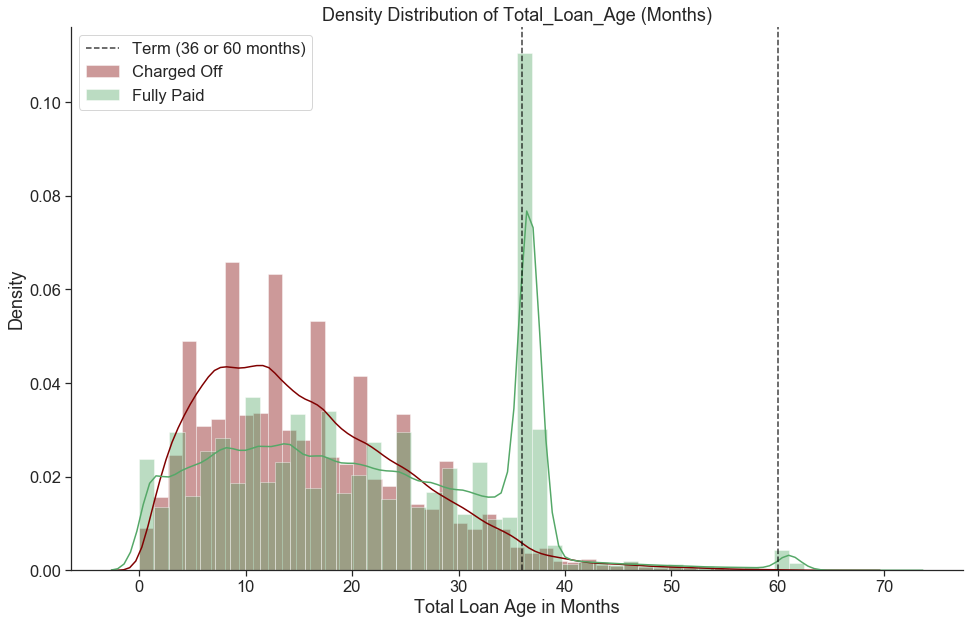

In [16]:
fig, ax = plt.subplots(figsize=(16,10))

ages_df = loan_df[~loan_df['Total_Loan_Age'].isnull()][['loan_status','Total_Loan_Age']]

sns.distplot(ages_df[ages_df['loan_status']=='Charged Off']['Total_Loan_Age'],color='#800000',rug=False,label='Charged Off')
sns.distplot(ages_df[ages_df['loan_status']=='Fully Paid']['Total_Loan_Age'],color='#55a868',rug=False,label='Fully Paid')

#Set Term Lengths
plt.axvline(36,color='black',linestyle='--',alpha=0.75,label='Term (36 or 60 months)')
plt.axvline(60,color='black',linestyle='--',alpha=0.75)

ax.set_title('Density Distribution of Total_Loan_Age (Months)')
ax.set_xlabel('Total Loan Age in Months')
ax.set_ylabel('Density')
plt.legend(loc='upper left')

sns.despine();

<b>From what we see from these two plots, we need to be careful when selection year ranges for our data. 
If we use loans that have not had a full 36 months or 60 months since it was issued, we may be running into selection bias as we would be selecting borrowers who pay off loans early and not borrowers who pay on schedule for the whole term.</b>


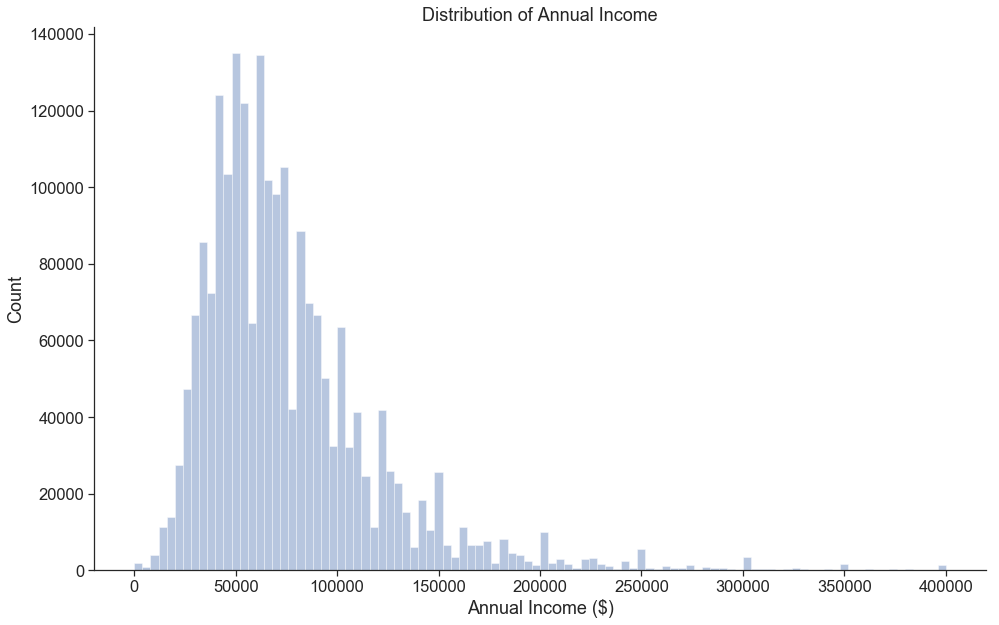

In [17]:
fig, ax = plt.subplots(figsize=(16,10))

sns.distplot(loan_df[loan_df['annual_inc']<=400000]['annual_inc'],bins=100,kde=False,rug=False)


ax.set_title('Distribution of Annual Income')
ax.set_xlabel('Annual Income ($)')
ax.set_ylabel('Count')

sns.despine();

<b>Majority of loans from lenderclub have applicants with income of around 50k to 70k a year.
<br>There seems to be loans given to people with very low income including income of 0, however, this maybe due to people who recently lost their jobs, had employment change, or has a cosigner</b>

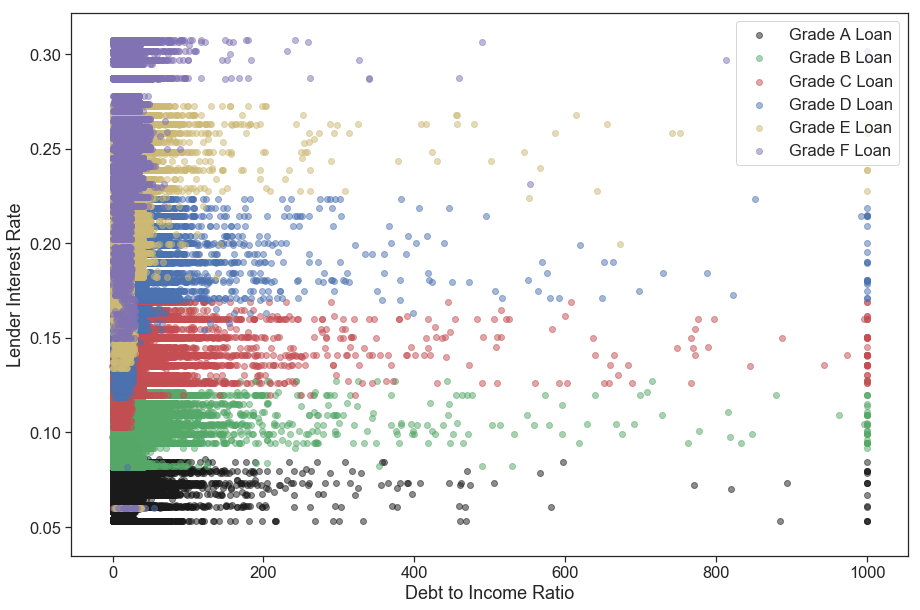

In [18]:
loan_df['interest_rate']=loan_df['int_rate'].str.replace("%","").astype(float)/100

#Interest Rates change over time. Let's look at 2018Q2 only.
tmp_df = loan_df[(loan_df['issue_d']>=datetime(2018,4,1))|(loan_df['issue_d']<datetime(2018,7,1))]

colors=['k','g','r','b','y','m','c']
counter=0
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for grade in np.sort(tmp_df['grade'].unique()[0:-1]):
    ax.scatter(tmp_df[tmp_df['grade']==grade].dti, tmp_df[tmp_df['grade']==grade].interest_rate, 
                alpha=0.5, color=colors[counter], label='Grade '+ grade+ ' Loan')
    counter+=1

ax.set_xlabel('Debt to Income Ratio')
ax.set_ylabel('Lender Interest Rate')
ax.legend(loc='best');


<b>Riskier loans tend to have higher interest rates (From A to G represents least to greatest risk)
<br>Riskier applicants also tend to have higher debt to income ratio
<br>These risks should be considered during the loan applicant's assessment

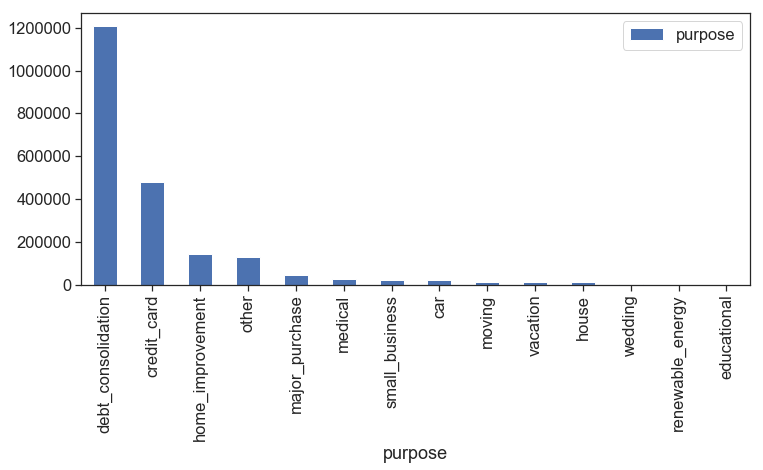

In [19]:
fund_purpose=pd.DataFrame(loan_df.groupby('purpose')['purpose'].agg('count').sort_values(ascending=False))
fund_purpose.plot(kind='bar', figsize=(12,5));

<b>Majority of loans pertain to paying off debt including consolidating debt and paying of credit_cards
<br>Based on this information along with the distribution of income, these may be individuals who are 
<br>looking get by while paying off their loans without affecting their credit, but do not have the ability to save

In [20]:
#Drop created columns before cleaning
loan_df = loan_df.drop(['Total_Loan_Age', 'interest_rate'],1)

### <font color='maroon'>Data Cleaning</font>


<b>Check for and Clean Missing Data</b>
<br>A visual check at the data set shows that there are several columns with a large number of null values. Let's identify these columns.

In [21]:
#Select rows with labels only
loan_df = loan_df[~loan_df['Risk'].isnull()]
print('Total Number of Rows:', '{:,}'.format(loan_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(loan_df.shape[1]))

#Number of null values by column
missing_values = pd.DataFrame(loan_df.isnull().sum(),columns=['Missing_Count'])
#Ratio of null values by column
missing_values['Missing_Ratio'] = missing_values['Missing_Count']/loan_df.shape[0]

#Sort by Missing_Count
missing_values = missing_values.sort_values(by='Missing_Count',ascending=False)

missing_values.head(5)

Total Number of Rows: 1,150,372
Total Number of Columns: 146


,Missing_Count,Missing_Ratio
id,1150372,1.000000
member_id,1150372,1.000000
next_pymnt_d,1150372,1.000000
url,1150372,1.000000
orig_projected_additional_accrued_interest,1148091,0.998017


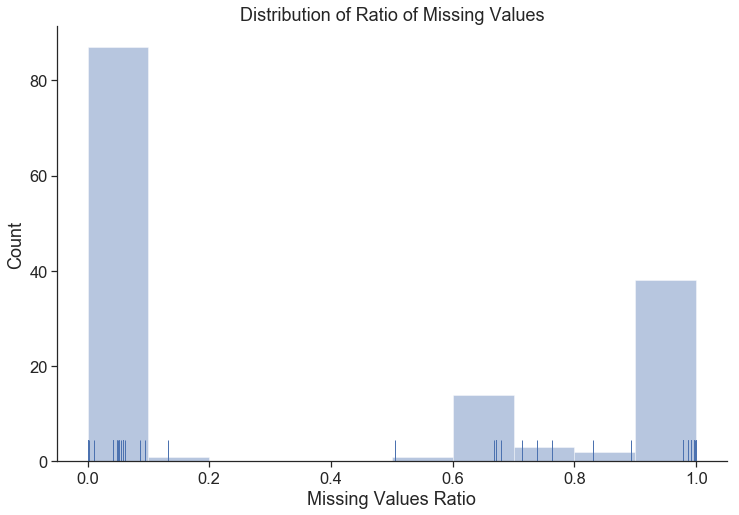

In [22]:
#Plot the distribution of Ratio of missing values
fig, ax = plt.subplots(figsize=(12,8))

sns.distplot(missing_values['Missing_Ratio'], bins=10, kde=False, rug=True)
ax.set_title('Distribution of Ratio of Missing Values')
ax.set_xlabel('Missing Values Ratio')
ax.set_ylabel('Count')

sns.despine()

In [23]:
print('Number of Columns with under 15% missing values:', missing_values[missing_values['Missing_Ratio']<=0.15].shape[0])

Number of Columns with under 15% missing values: 88


We see that there are 88 columns (including our response variable) that are quite safe to include in our data set after some imputation as they have less than 15% missing values.

Outside of these columns, the remainder are over 50% missing values and quite risky to impute values for.

In [24]:
#Combine current set of potential features
potential_features = missing_values[missing_values['Missing_Ratio']<=0.15].index.values

potential_features

array(['mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct',
       'emp_title', 'pct_tl_nvr_dlq', 'avg_cur_bal',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_old_rev_tl_op', 'num_rev_accts',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_tl', 'num_il_tl', 'num_tl_op_past_12m', 'mo_sin_rcnt_tl',
       'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_30dpd',
       'total_il_high_credit_limit', 'tot_hi_cred_lim',
       'num_tl_90g_dpd_24m', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'emp_length', 'bc_util', 'percent_bc_gt_75',
       'bc_open_to_buy', 'mths_since_recent_bc', 'num_bc_sats',
       'num_sats', 'mort_acc', 'total_bal_ex_mort', 'total_bc_limit',
       'acc_open_past_24mths', 'title', 'last_pymnt_d',
       'pub_rec_bankruptcies', 'revol_util', 'dti',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'last_credit_pull_d', 'tax_liens', 'inq_last_6mths', 'out_prncp',
       'sub_grade', 'pymnt_

Before we go on, we should look into the current column types for any string 'object' types.

In [25]:
types_df = pd.DataFrame(loan_df[potential_features].dtypes,columns=['Types'])
types_df.head(5)

,Types
mths_since_recent_inq,float64
num_tl_120dpd_2m,float64
mo_sin_old_il_acct,float64
emp_title,object
pct_tl_nvr_dlq,float64


In [26]:
#Subset non-float64 
types_df[types_df['Types']!='float64']

,Types
emp_title,object
emp_length,object
title,object
last_pymnt_d,datetime64[ns]
revol_util,object
last_credit_pull_d,object
sub_grade,object
pymnt_plan,object
loan_status,object
issue_d,datetime64[ns]


Start creating a list of categorical variables for future one-hot encoding and remove problematic columns.
<br><br><b>emp_title</b> - The job title supplied by the Borrower when applying for the loan.
<br>Unfortunately, this is a human inputted field so the dimensionality is too high and is most likely largely covered by <b>annual_inc</b> (self-reported annual income). <br>Potentially we could combine this column into job industry bins if an online database is avaliable but the work to potential benefit ratio is questionable.

In [27]:
#Remove 'emp_title'
print('Unique \'emp_title\' inputs: ', '{:,}'.format(loan_df['emp_title'].nunique()))
potential_features = potential_features[potential_features != 'emp_title']

Unique 'emp_title' inputs:  345,433


<b>emp_length</b> - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
<br>We are unable to change this to a continuous variable but we can reduce the number of categorical bins to help reduce potential overfitting and fill in any missing values. 
<br>We aim to create fewer and more even bins. We will treat any nulls as 0 years worked as they most often appear when no 'emp_title' is listed.

In [28]:
loan_df['emp_length'].unique()

array(['7 years', '10+ years', '2 years', '5 years', '3 years', '4 years',
       '6 years', '1 year', '9 years', '8 years', '< 1 year', nan],
      dtype=object)

In [29]:
loan_df.groupby('emp_length')['emp_length'].agg('count')

emp_length
1 year        75422
10+ years    377480
2 years      104052
3 years       91919
4 years       68824
5 years       72404
6 years       54431
7 years       52509
8 years       53089
9 years       44195
< 1 year      91870
Name: emp_length, dtype: int64

In [30]:
#0-1 years inclues: null, None, < 1 year, 1 year
loan_df['emp_length'] = np.where(loan_df['emp_length'].isin([np.nan,None,'< 1 year','1 year']),
                                 '0-1 years',loan_df['emp_length'])
loan_df['emp_length'] = loan_df['emp_length'].fillna('0-1 years')

#2-4 years inclues: 2 years, 3 years, 4 years
loan_df['emp_length'] = np.where(loan_df['emp_length'].isin(['2 years','3 years','4 years']),
                                 '2-4 years',loan_df['emp_length'])

#5-9 years inclues: 5 years, 6 years, 7 years, 8 years, 9 years
loan_df['emp_length'] = np.where(loan_df['emp_length'].isin(['5 years','6 years','7 years','8 years','9 years']),
                                 '5-9 years',loan_df['emp_length'])

#10+ years includes 10+ years (no change)

In [31]:
loan_df.groupby('emp_length')['emp_length'].agg('count')

emp_length
0-1 years    231469
10+ years    377480
2-4 years    264795
5-9 years    276628
Name: emp_length, dtype: int64

<b>title</b> - The loan title provided by the borrower
<br> This field is already neatly organized into set categorizes in <b>purpose</b> so we will remove this column.

In [32]:
potential_features = potential_features[potential_features != 'title']

<b>last_pymnt_d</b> - Last month payment was received
<br> This column won't be avaliable before a loan is funded so we will remove it.

In [33]:
potential_features = potential_features[potential_features != 'last_pymnt_d']

<b>revol_util</b> - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
<br> Currently a string percent (%) so it was not casted properly. Temporarily set nulls as -1 to cast the column to float.

In [34]:
loan_df['revol_util'] = loan_df['revol_util'].fillna(-100)
loan_df['revol_util'] = loan_df['revol_util'].apply(lambda x: float(str(x).split('%')[0])/100)
loan_df['revol_util'] = np.where(loan_df['revol_util']==-1.0,np.nan,loan_df['revol_util'])

<b>last_credit_pull_d</b> - The most recent month LC pulled credit for this loan
<br>This column won't be avaliable before a loan is funded so we will remove this as well. 

In [35]:
potential_features = potential_features[potential_features != 'last_credit_pull_d']

<b>earliest_cr_line</b> - The month the borrower's earliest reported credit line was opened
<br>This date alone won't be much use so we will generate <b>credit_line_age</b> as the number of days between <b>earliest_cr_line</b> and <b>issue_d</b> and remove this column.

In [36]:
#Cast issue_d to datetime
loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'])

loan_df['credit_line_age'] = loan_df['issue_d'] - pd.to_datetime(loan_df['earliest_cr_line'])
loan_df['credit_line_age'] = loan_df['credit_line_age'].apply(lambda x: x.days)

potential_features = potential_features[potential_features != 'earliest_cr_line']
potential_features = np.append(potential_features,['credit_line_age'])

<b>zip_code</b> - The first 3 numbers of the zip code provided by the borrower in the loan application.
<br>We will remove this for now for the sake of fairness <b>???</b>

In [37]:
potential_features = potential_features[potential_features != 'zip_code']

<b>verification_status</b> - Indicates if income was verified by LC, not verified, or if the income source was verified
<br>This is already neatly categorized. We will fill any nulls as 'Not Verified'

In [38]:
loan_df['verification_status'].unique()

array(['Not Verified', 'Verified', 'Source Verified'], dtype=object)

In [39]:
loan_df['verification_status'] = loan_df['verification_status'].fillna('Not Verified')

<b>home_ownership</b> - The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
<br>This is already neatly categorized with no missing values. 

In [40]:
loan_df['home_ownership'].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'NONE', 'OTHER', 'ANY'], dtype=object)

<b>disbursement_method</b> - The method by which the borrower receives their loan. Possible values are: CASH, DIRECT_PAY
<br>This is already neatly categorized with no missing values. 

In [41]:
loan_df['disbursement_method'].unique()

array(['Cash', 'DirectPay'], dtype=object)

<b>sub_grade</b> - LC assigned loan subgrade
<br>This is already neatly categorized with no missing values.

In [42]:
loan_df['sub_grade'].unique()

array(['B1', 'A2', 'B5', 'B2', 'B3', 'A3', 'E4', 'A5', 'B4', 'D5', 'C3',
       'C2', 'C1', 'C5', 'C4', 'E1', 'D4', 'D3', 'A4', 'A1', 'D2', 'D1',
       'E3', 'F1', 'E5', 'E2', 'G3', 'G1', 'F2', 'F4', 'F5', 'G5', 'G4',
       'F3', 'G2'], dtype=object)

<b>grade</b> - LC assigned loan grade
<br>Since we have <b>sub_grade</b> already we will remove this.

In [43]:
potential_features = potential_features[potential_features != 'grade']

<b>debt_settlement_flag</b> - Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.
<br>This won't be avaliable at the the time a loan is funded so we will remove this feature.

In [44]:
potential_features = potential_features[potential_features != 'debt_settlement_flag']

<b>int_rate</b> - Interest Rate on the loan
<br>Currently a string percent (%) so it was not casted properly.

In [45]:
 loan_df['int_rate'] = loan_df['int_rate'].apply(lambda x: float(str(x).split('%')[0])/100)

<b>term</b> - The number of payments on the loan. Values are in months and can be either 36 or 60.
<br>This is already neatly categorized with no missing values. 

In [46]:
loan_df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

<b>pymnt_plan</b> - Indicates if a payment plan has been put in place for the loan.
<br>All values will be "n" for "Fully Paid" or "Charged Off" loans so we will remove this.

In [47]:
potential_features = potential_features[potential_features != 'pymnt_plan']

<b>application_type</b> - Indicates whether the loan is an individual application or a joint application with two co-borrowers
<br>This is already neatly categorized with no missing values. 

In [48]:
loan_df['application_type'].unique()

array(['Individual', 'Joint App'], dtype=object)

<b>purpose</b> - A category provided by the borrower for the loan request. 
<br>This is already neatly categorized with no missing values. 

In [49]:
loan_df['purpose'].unique()

array(['debt_consolidation', 'home_improvement', 'credit_card', 'other',
       'major_purchase', 'small_business', 'house', 'moving', 'medical',
       'car', 'vacation', 'renewable_energy', 'wedding', 'educational'],
      dtype=object)

<b>initial_list_status</b> - The initial listing status of the loan. Possible values are – W, F
<br>This is already neatly categorized with no missing values. 

In [50]:
loan_df['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

<b>hardship_flag</b> - Flags whether or not the borrower is on a hardship plan
<br>This is already neatly categorized with no missing values. 

In [51]:
loan_df['hardship_flag'].unique()

array(['N'], dtype=object)

<b>addr_state</b> - The state provided by the borrower in the loan application
<br>This is already neatly categorized with no missing values.

In [52]:
loan_df['addr_state'].unique()

array(['MA', 'CT', 'NY', 'MI', 'TX', 'CO', 'CA', 'FL', 'NM', 'NC', 'IN',
       'OH', 'AZ', 'SC', 'PA', 'DE', 'NJ', 'GA', 'UT', 'MO', 'WI', 'IL',
       'MD', 'WA', 'TN', 'WY', 'VA', 'KY', 'MN', 'NH', 'NV', 'KS', 'RI',
       'AL', 'WV', 'LA', 'OR', 'VT', 'AR', 'OK', 'MT', 'HI', 'AK', 'SD',
       'DC', 'NE', 'IA', 'MS', 'ID', 'ME', 'ND'], dtype=object)

<b>policy_code</b> - publicly available policy_code=1 and new products not publicly available policy_code=2
<br>All values will be "n" for "Fully Paid" or "Charged Off" loans so we will remove this.

In [53]:
potential_features = potential_features[potential_features != 'policy_code']

In [54]:
#Rerun Types
types_df = pd.DataFrame(loan_df[potential_features].dtypes,columns=['Types'])
types_df[types_df['Types']!='float64']

,Types
emp_length,object
sub_grade,object
loan_status,object
issue_d,datetime64[ns]
verification_status,object
home_ownership,object
application_type,object
disbursement_method,object
term,object
purpose,object


While we will not be using <b>issue_d</b> as a feature, we will not remove it at this point in case we need to sample or sort by date. This will be removed later before model training.

In [55]:
categoricals = types_df[types_df['Types']=='object'].index.values
categoricals = categoricals[categoricals!='loan_status']
categoricals

array(['emp_length', 'sub_grade', 'verification_status', 'home_ownership',
       'application_type', 'disbursement_method', 'term', 'purpose',
       'addr_state', 'initial_list_status', 'hardship_flag'], dtype=object)

We now need to look through our continous variables and look for features not avaliable at the time of funding and remove them. We will need to go through this by hand.

In [56]:
types_df[types_df['Types']=='float64'].index.values

array(['mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct',
       'pct_tl_nvr_dlq', 'avg_cur_bal', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_old_rev_tl_op', 'num_rev_accts', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl',
       'num_tl_op_past_12m', 'mo_sin_rcnt_tl', 'num_op_rev_tl',
       'num_rev_tl_bal_gt_0', 'num_tl_30dpd',
       'total_il_high_credit_limit', 'tot_hi_cred_lim',
       'num_tl_90g_dpd_24m', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'bc_util', 'percent_bc_gt_75',
       'bc_open_to_buy', 'mths_since_recent_bc', 'num_bc_sats',
       'num_sats', 'mort_acc', 'total_bal_ex_mort', 'total_bc_limit',
       'acc_open_past_24mths', 'pub_rec_bankruptcies', 'revol_util',
       'dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'tax_liens', 'inq_last_6mths', 'out_prncp', 'annual_inc',
       'last_pymnt_amnt', 'installment', 'int_rate', 'funded_amnt_inv',
       'funded_amnt', 

In [57]:
not_at_funding = ['collection_recovery_fee',
                    'funded_amnt',
                    'funded_amnt_inv',
                    'last_pymnt_amnt',
                    'out_prncp',
                    'out_prncp_inv',
                    'recoveries',
                    'total_pymnt',
                    'total_pymnt_inv',
                    'total_rec_int',
                    'total_rec_late_fee',
                    'total_rec_prncp']

potential_features = np.setdiff1d(potential_features,not_at_funding)

<b>Impute Missing Values for the Remaining Continuous Variables</b>
<br>We will use linear model imputation in order of columns from the most to the least missing values. 
<br>Any nulls will temporarily filled with mean imputation until the column is filled.

In [58]:
#Subset potential features only and update types_df 
loan_df = loan_df[potential_features]
types_df = pd.DataFrame(loan_df[potential_features].dtypes,columns=['Types'])

#Encode categoricals
loan_df = pd.get_dummies(loan_df,columns=categoricals,drop_first=True) 

In [60]:
missing_columns = types_df[types_df['Types']=='float64'].index.tolist()
missing_columns = missing_values.loc[missing_columns].sort_values(by='Missing_Count',ascending=False)
missing_columns = missing_columns[missing_columns['Missing_Count'] != 0].index.tolist()

clean_df = loan_df.copy()

for column in missing_columns:
    excluded_columns = ['issue_d','loan_status','Risk']
    # Remove response variable
    impute_train = clean_df[~clean_df[column].isnull()].drop(excluded_columns,1).sample(100000,random_state=12)
    
    #Split target
    X_impute_train = impute_train.drop(column,1)
    Y_impute_train = impute_train[column]
    
    #Mean Imputation for current nulls for columns that did not get imputed yet
    X_impute_train = X_impute_train.fillna(X_impute_train.mean())

    # Train LinearRegression
    impute_ols = LinearRegression(fit_intercept=True)
    impute_ols.fit(X_impute_train,Y_impute_train)

    # Generate new temp column with model predictions
    # Only replace rows where the value is null with the K-NN predicted value 
    predictions = clean_df.drop(excluded_columns + [column],1)
    
    #Mean Imputation for current nulls for columns that did not get imputed yet
    predictions = predictions.fillna(predictions.mean())
    clean_df['temp'] = impute_ols.predict(predictions)
    
    clean_df[column] = np.where(clean_df[column].isnull(),clean_df['temp'],clean_df[column])
    clean_df = clean_df.drop('temp',1)


In [61]:
#Store as pickle
clean_df.to_pickle('./data/clean_df.pkl')

In [62]:
#Number of null values by column
missing_values = pd.DataFrame(clean_df.isnull().sum(),columns=['Missing_Count'])
#Ratio of null values by column
missing_values['Missing_Ratio'] = missing_values['Missing_Count']/clean_df.shape[0]

#Sort by Missing_Count
missing_values = missing_values.sort_values(by='Missing_Count',ascending=False)

missing_values.head(5)

,Missing_Count,Missing_Ratio
Risk,0,0.0
purpose_educational,0,0.0
purpose_house,0,0.0
purpose_major_purchase,0,0.0
purpose_medical,0,0.0


<hr style="height:1.5pt">
### <font color='maroon'>Random Forest Feature Importances</font>
<br>We currently still have a large number of columns that we'd like to narrow down. 
<br>We will train a Random Forest Classifier and use the feature importances to select the top features.
<br>We specifically set max_depth=None to allow for all features to be incorporated.

In [65]:
X_train = clean_df.drop(['issue_d','loan_status','Risk'],1)
y_train = clean_df['Risk']

#Let max_depth potentially overfit
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None).fit(X_train, y_train)

In [66]:
importances = pd.DataFrame({'Columns':X_train.columns,'Feature_Importances':rf_model.feature_importances_})
importances = importances.sort_values(by='Feature_Importances',ascending=False)

In [67]:
importances

,Columns,Feature_Importances
14,int_rate,4.465759e-02
11,dti,3.094219e-02
13,installment,2.676424e-02
4,bc_open_to_buy,2.597622e-02
47,tot_hi_cred_lim,2.570249e-02
3,avg_cur_bal,2.569512e-02
17,mo_sin_old_rev_tl_op,2.525365e-02
2,annual_inc,2.493183e-02
5,bc_util,2.478203e-02
8,credit_line_age,2.475001e-02


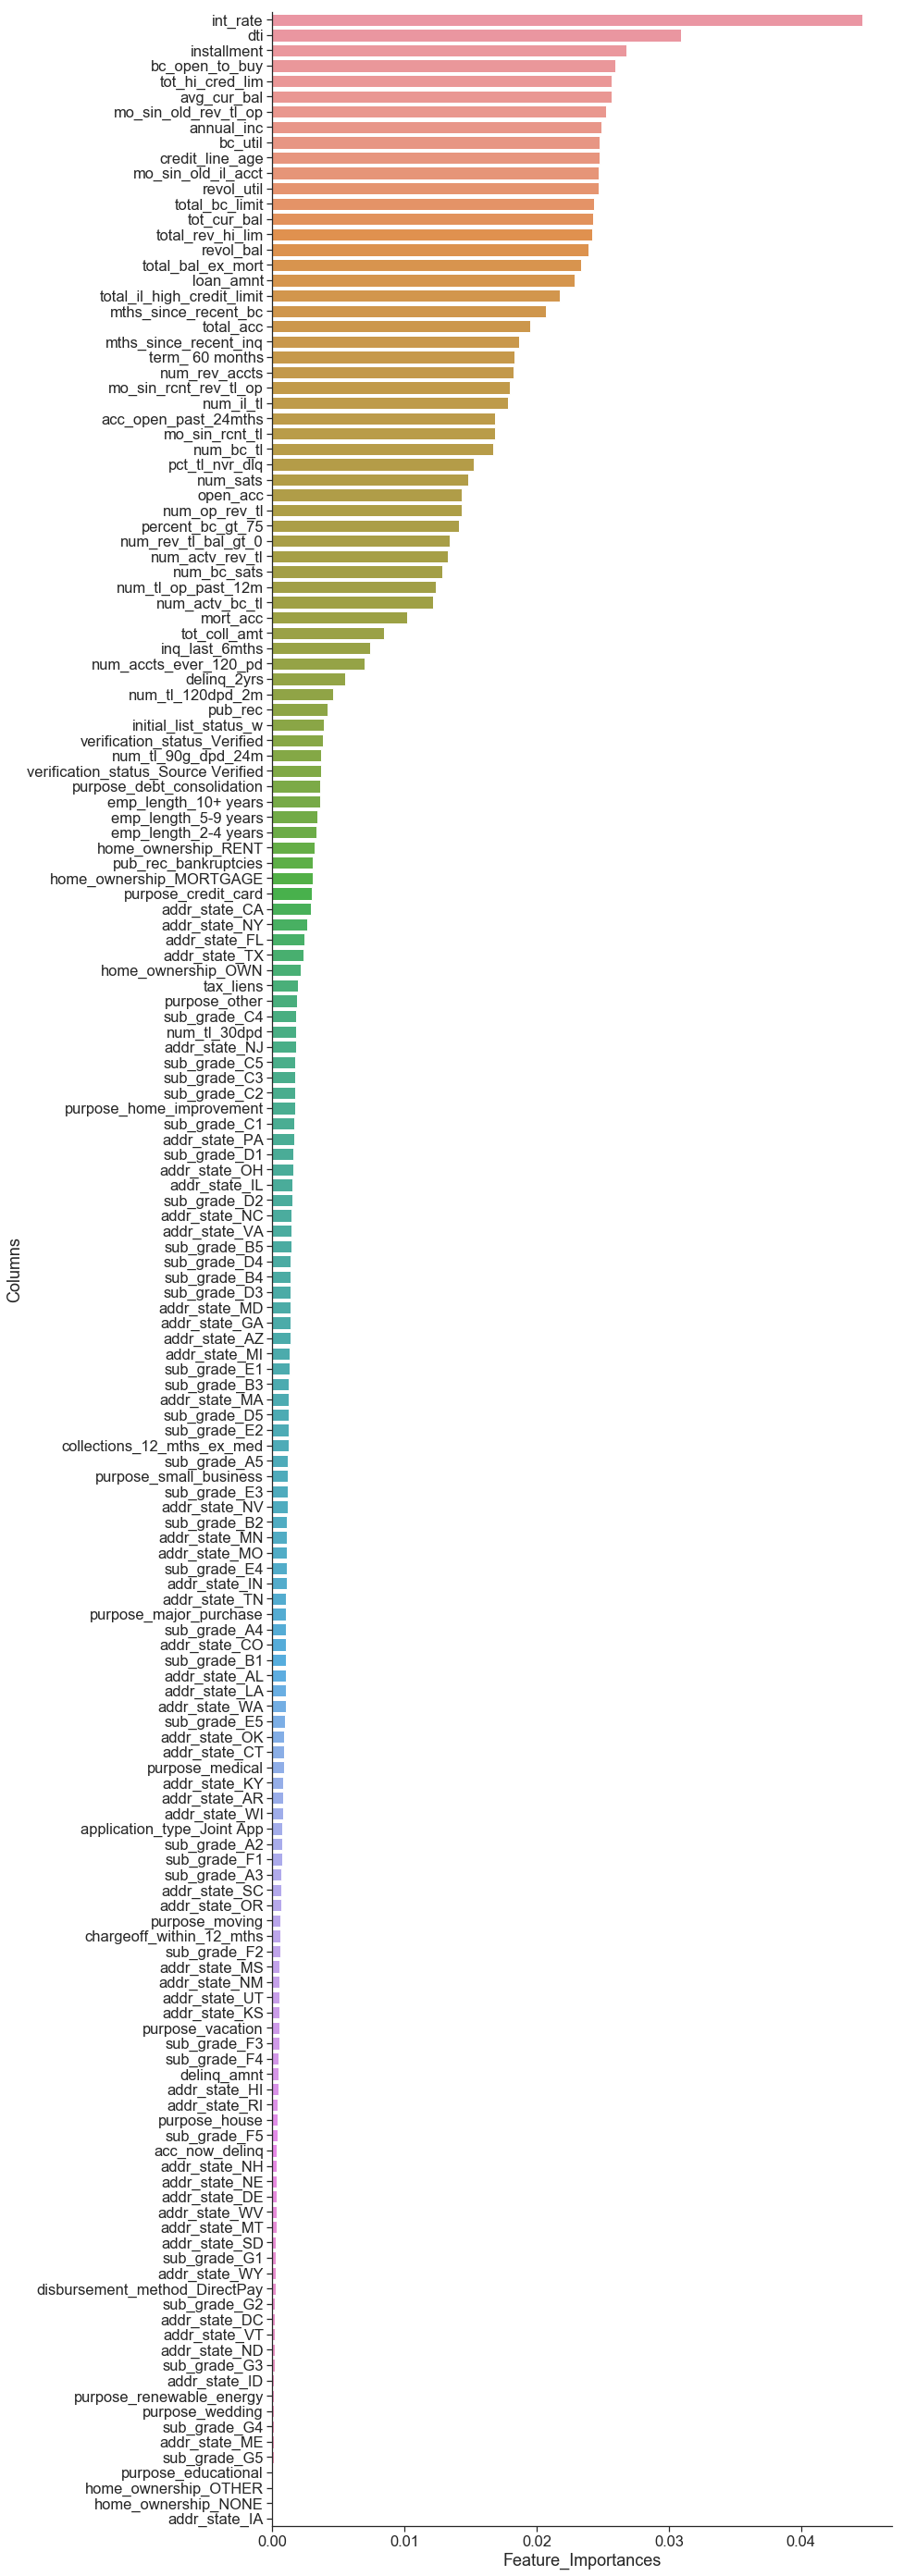

In [68]:
fig, ax = plt.subplots(figsize=(12,50))

ax = sns.barplot(x=importances['Feature_Importances'], y=importances['Columns'])

sns.despine()

For a baseline, we will be conservative in our chosen features and slowly increase them in future tests.

In [83]:
top_features = importances[importances['Feature_Importances']>=0.0225]['Columns'].values.tolist()
top_features

['int_rate',
 'dti',
 'installment',
 'bc_open_to_buy',
 'tot_hi_cred_lim',
 'avg_cur_bal',
 'mo_sin_old_rev_tl_op',
 'annual_inc',
 'bc_util',
 'credit_line_age',
 'mo_sin_old_il_acct',
 'revol_util',
 'total_bc_limit',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'revol_bal',
 'total_bal_ex_mort',
 'loan_amnt']

<hr style="height:1.5pt">
### <font color='maroon'>Baseline Model - Decision Tree Classifier</font>


Since we have performed feature selection using Random Forest, we will use a single Decision Tree as our baseline with the top features chosen by feature importances. 
<br>We will also train a Logistic Regression for reference but we should remember that the features were chosen by a tree and may not be optimal for Logistic Regression.

In [87]:
#Subset to Top Features
outcome='Risk'

baseline_df = clean_df[top_features + [outcome]]

In [93]:
#Split Train and Test Sets
data_train, data_test = train_test_split(baseline_df, test_size=.1, stratify=baseline_df[outcome], random_state=99);

X_train = data_train.drop(columns=[outcome])
y_train = data_train[outcome]

X_test = data_test.drop(columns=[outcome])
y_test = data_test[outcome]

As we noted previously, the label data is imbalanced. In the baseline we will compare accuracy metrics to the accuracy that would be obtained if we generated a model that predicted all loans to be fully paid. To expand from this baseline, we will deal with the imbalance and incorporate fairness metrics to account for unpredicted biases.

In [94]:
most_common_class = data_train['Risk'].value_counts().idxmax()

# training set baseline accuracy
baseline_accuracy = np.sum(data_train['Risk']==most_common_class)/len(data_train)

print("Classification accuracy (training set) if we predict all loans to be fully paid: {:.3f}"
      .format(baseline_accuracy))

Classification accuracy (training set) if we predict all loans to be fully paid: 0.800


In [ ]:
tree_cv_scores = []
for i in range(2,20):
  clf = DecisionTreeClassifier(criterion='gini', max_depth=i)
  clf.fit(X_train, y_train)
  train_score = clf.score(X_train, y_train)
  cv_score = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
  tree_cv_scores.append({'Depth': i,
                        'Train Score': train_score,
                        'CV Mean Accuracy': cv_score.mean()})

In [98]:
columns=['Depth', 'Train Score','CV Mean Accuracy']
tree_scores_df = pd.DataFrame(tree_cv_scores, columns=columns)
tree_scores_df.round(4)

,Depth,Train Score,CV Mean Accuracy
0,2,0.8005,0.8005
1,3,0.8005,0.8005
2,4,0.8005,0.8005
3,5,0.8005,0.8005
4,6,0.8013,0.8012
5,7,0.8016,0.8013
6,8,0.8022,0.8013
7,9,0.8027,0.8007
8,10,0.8039,0.8002
9,11,0.8056,0.7990


In [97]:
from sklearn.linear_model import LogisticRegressionCV

#logistic regression model
lrm = LogisticRegressionCV(cv=5)

cv_scores = cross_val_score(lrm, X_train, y_train, cv=5)

print("cross_val_scores, baseline logistic regression model: \n{}"
     .format(cv_scores))
print("mean cv score:{:4.4f}\n".format(cv_scores.mean()))

cross_val_scores, baseline logistic regressino model: 
[0.79953928 0.80045589 0.79998744 0.79969672 0.79997682]
mean cv score:0.7999



We can see that the baseline accuracy values are quite poor. There will be a large space to improve on going forward.